In [556]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.filters import sobel
from skimage import exposure
from skimage.restoration import denoise_bilateral
from skimage.feature import canny
from skimage import color
from skimage.feature import ORB, SIFT, BRIEF
from skimage.feature import match_descriptors
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.measure import ransac
from skimage.registration import phase_cross_correlation
from skimage.transform import EuclideanTransform
from skimage.transform import SimilarityTransform
from skimage.transform import warp, AffineTransform, rotate, resize
from skimage import data
from __future__ import print_function
import cv2
from PIL import Image

In [935]:
# Importing the reference (model) and moving (data) images
# Make sure to convert the imgages to type int or bool not float
img_model_org = np.array(Image.open('gray_scale/Shoe20R-1-143.6-F1.png'))
img_data_org = np.array(Image.open('gray_scale/Shoe20R-1-205-F1.png'))

In [936]:
def binarize_image(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    binary = exposure.equalize_adapthist(binary, clip_limit=0.03)
    return binary

# display the image
def show_image(image, title='Image', cmap_type='gray'):
    plt.figure(figsize = (10, 15))
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# binarize and enhance the image    
def preprocess(image_list, rescale=False, binarize=True,
              new_scan=True, exemplar=False):
    return_list = []
    for img in image_list:
        if new_scan:
            # crop the hand writing and denoise
            ydim, xdim = img.shape
            box_width = 900
            box_height = 600
            if exemplar:
                img = img.astype(bool)
                img[:,:300] = colorize_image(img[:,:300],[255,255,255])[:,:,1]
                img[:,xdim-300:xdim] = colorize_image(img[:,xdim-300:xdim],[255,255,255])[:,:,1]
                pic_grayscale_cropped = img.astype(int)
            else:
                img[ydim-box_height:ydim,xdim-box_width:xdim] = colorize_image(img[ydim-box_height:ydim, 
                                                                                              xdim-box_width:xdim],
                                                                  [255,255,255])[:,:,1]
                pic_grayscale_cropped = img[:,100:xdim].astype(int)
        else:
            pic_grayscale = color.rgb2gray(img)
            ruler_length = 159
            ydim, xdim = pic_grayscale.shape[0], pic_grayscale.shape[1]
            pic_grayscale_cropped = pic_grayscale[ruler_length:ydim-ruler_length, 
                                                  ruler_length:xdim-ruler_length]
        if rescale:
            height = ydim/2
            width = xdim/2
            pic_grayscale_cropped = resize(pic_grayscale_cropped, 
                                   (height, width), 
                                   anti_aliasing=True)
        if binarize:
            binary = binarize_image(pic_grayscale_cropped)
        else:
            binary = pic_grayscale_cropped
        return_list.append(binary)
    return return_list

# save the image
def save_image(img, name):
    I = img
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

    img = Image.fromarray(I8)
    img.save(name)
    
# color the pixels
def colorize_image(img, color_code):
    if len(img.shape) == 2:
        img = color.gray2rgb(img)
    height, width, _ = img.shape
    for i in range(height):
        for j in range(width):
            if img[i, j, 0] < 0.5:
                img[i, j] = color_code
            else:
                img[i, j] = [255,255,255]
    return img

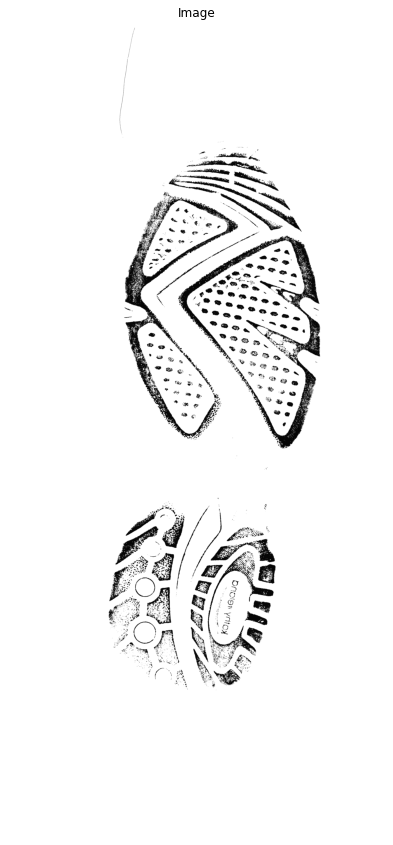

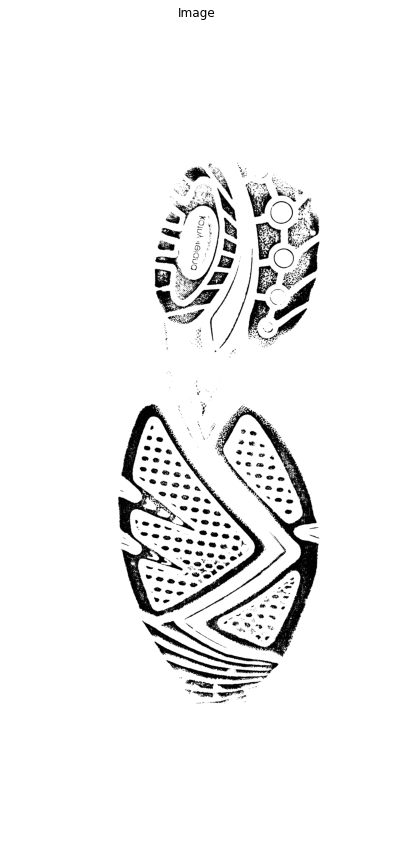

In [937]:
# preprocess images
processed_images = preprocess([img_model_org, img_data_org], 
                              rescale=False, binarize=True)
img_model, img_data = processed_images[0], processed_images[1]
show_image(img_model)
show_image(img_data)

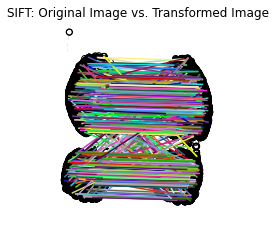

In [939]:
# extract features
img1 = img_model
img2 = img_data

# descriptor_extractor = ORB(n_keypoints=500)
descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, 
                              max_ratio=0.75, cross_check=True)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.gray()
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("SIFT: Original Image vs. Transformed Image")
# plt.savefig('Shoe03_M2_matched_SIFT.png', format='png', dpi=1500, bbox_inches='tight', pad_inches=0)
plt.show()

In [940]:
# Filter keypoints to remove non-matching
matches_ref, matches = keypoints1[matches12[:, 0]], keypoints2[matches12[:, 1]]

# Robustly estimate transform model with RANSAC
transform_robust, inliers = ransac((matches_ref, matches), SimilarityTransform, 
                                   min_samples = 5, residual_threshold = 0.5, 
                                   max_trials = 1000)
# Invert the translation
transform_robust = SimilarityTransform(rotation = transform_robust.rotation) + SimilarityTransform(translation = -np.flip(transform_robust.translation))

# Apply transformation to image
final_image = warp(img_data, transform_robust.inverse, order = 1, 
                   mode = "constant", cval = 1, 
                   clip = True, preserve_range = True)

# Binarize the pictures
final_image_binarized = final_image
img_model_binarized = img_model

In [941]:
# Use Phase Cross Correlation to adust linear transformation
shift, error, diffphase = phase_cross_correlation(img_model_binarized,
                                                  final_image_binarized, 
                                                  upsample_factor=100)
shift_transform = AffineTransform(translation = shift)
offset_image =  warp(final_image_binarized, shift_transform, 
                     mode='wrap', preserve_range=True)

In [951]:
# Export transformed grayscale images 
img1, img2 = preprocess([img_model_org, img_data_org], 
                              rescale=False, binarize=False)
img2_transformed = warp(img2, transform_robust.inverse, order = 1, 
                   mode = "constant", cval = 255, 
                   clip = True, preserve_range = True)
shift, error, diffphase = phase_cross_correlation(img1,
                                                  img2_transformed, 
                                                  upsample_factor=1000)
shift_transform = AffineTransform(translation = shift)
img2_transformed_offset =  warp(img2_transformed, shift_transform, 
                     mode='wrap', preserve_range=True)

In [952]:
save_image(offset_image, "max_weight/20.png")
save_image(img1, "no_weight/20.png")

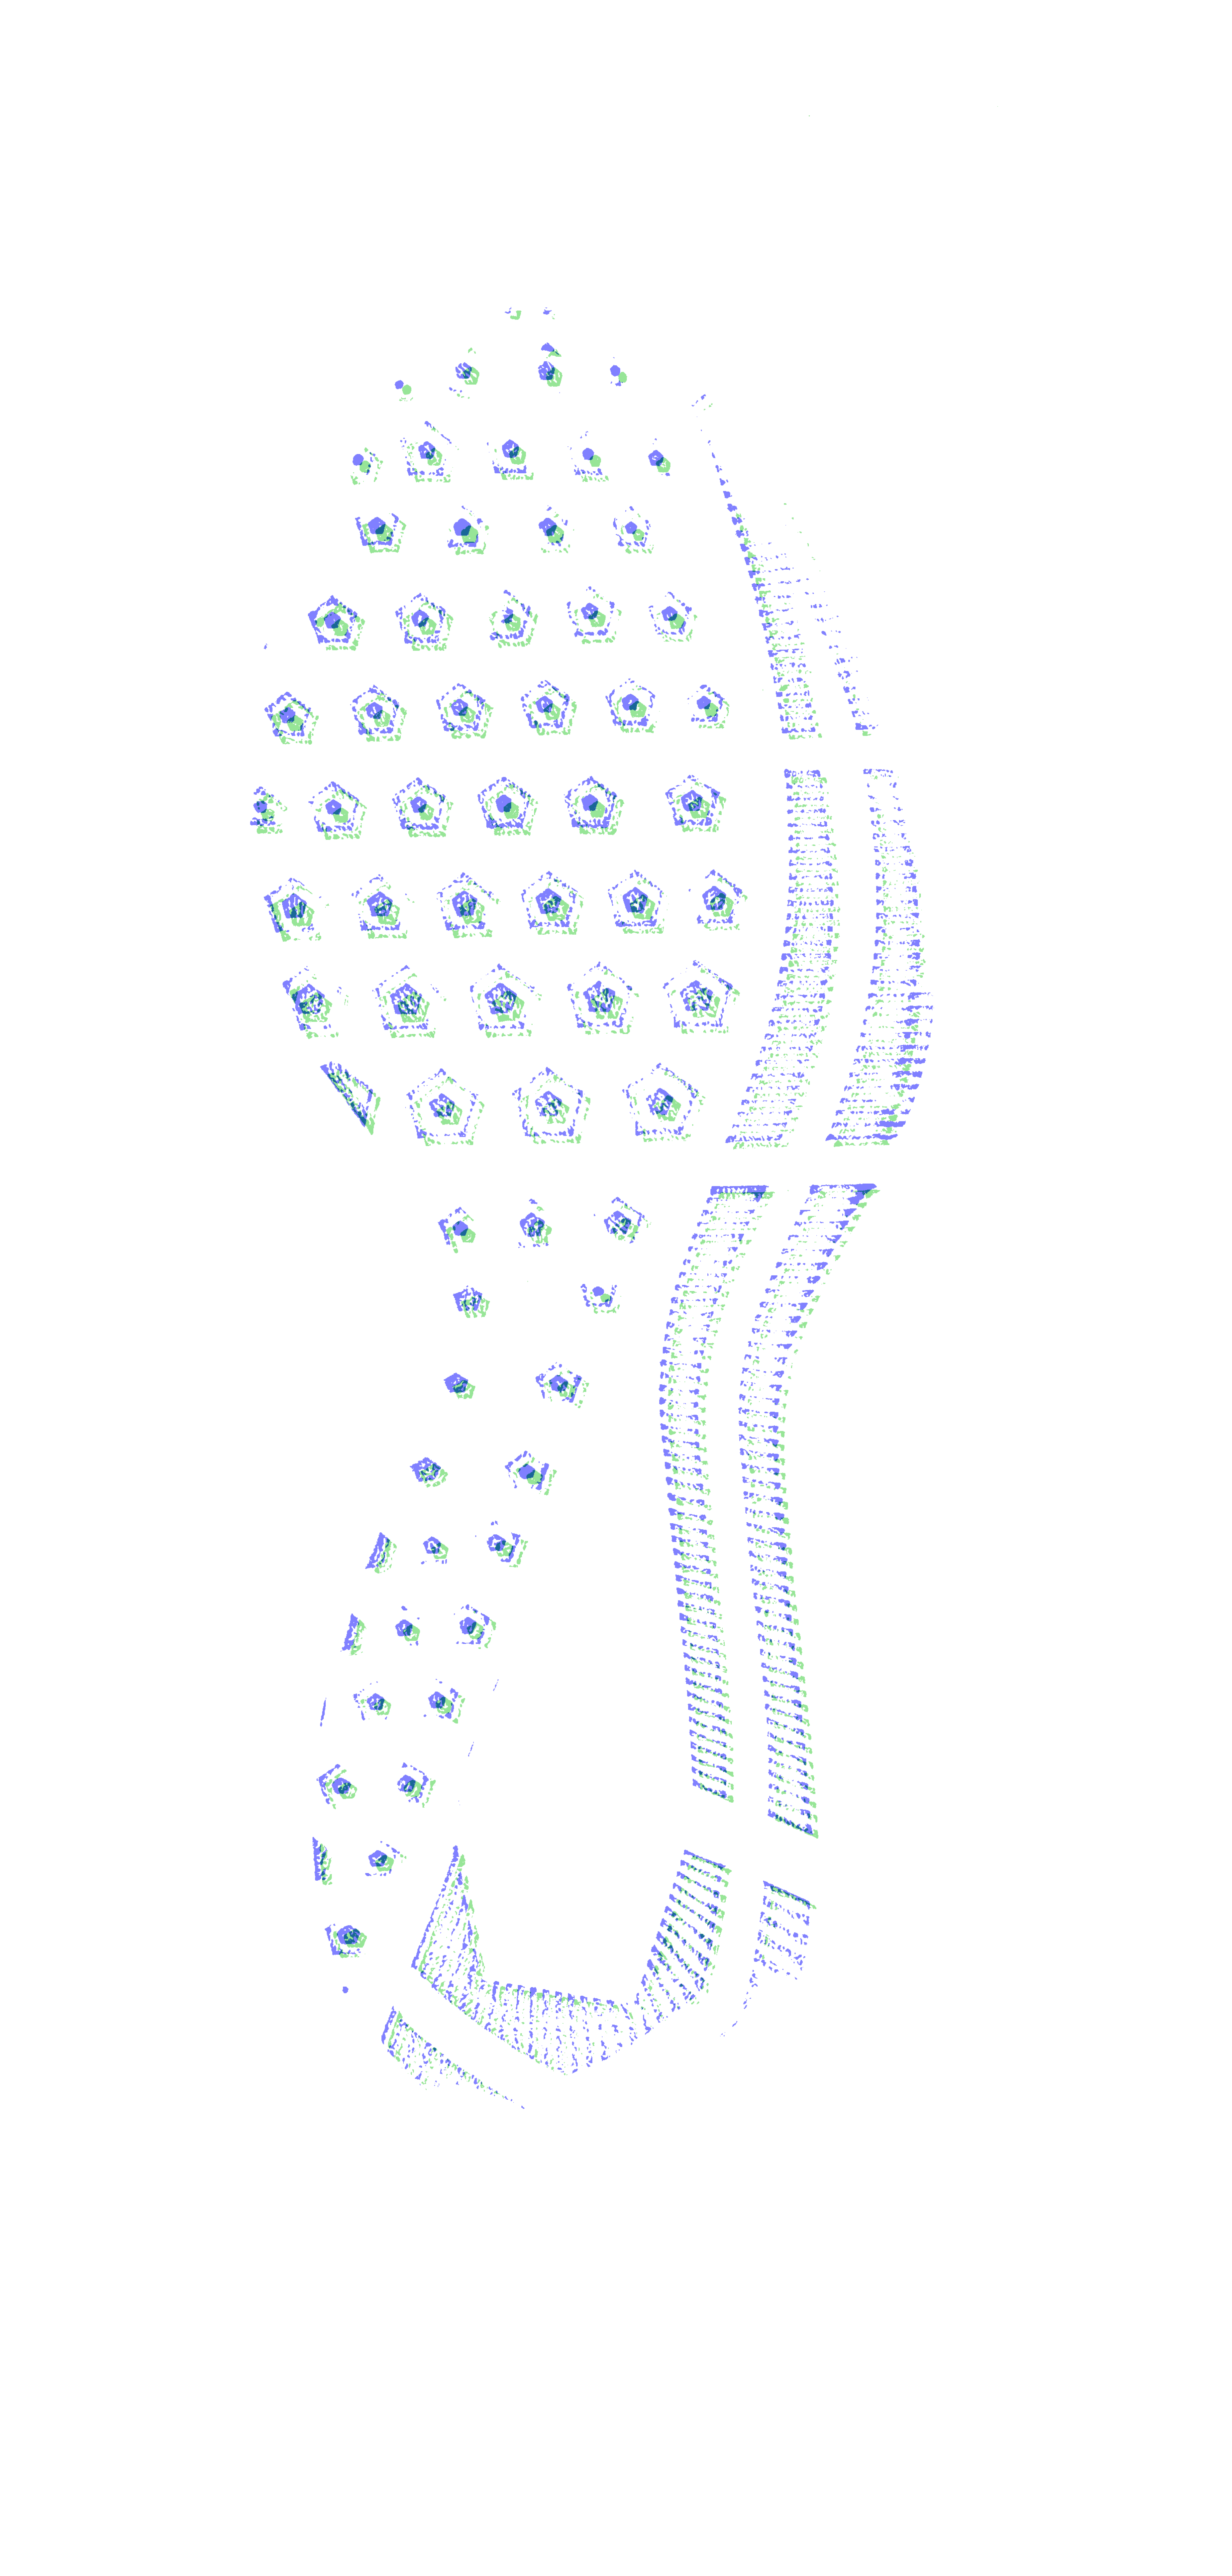

In [821]:
# Align and plot final image vs model image after POC
offset_image_colorized = colorize_image(offset_image,
                                                [0,0,255]).astype(int)
img_model_binarized_colorized = colorize_image(img_model_binarized,
                                                [50,205,50]).astype(int)
fig = plt.figure(figsize=(10, 10), dpi = 1000)
plt.imshow(img_model_binarized_colorized)
plt.imshow(offset_image_colorized, alpha = 0.5)
plt.axis('off')
plt.savefig('Aligned Images/shoe01_M2_150v211_official.png', 
            format='png', dpi=1500, bbox_inches='tight', pad_inches=0)

In [674]:
save_image(offset_image, "resnet_test/Shoe01R-2-211.4.0-M2-transformed.png")
save_image(img_model_binarized, "resnet_test/Shoe01R-2-150.0-M2-model.png")

In [ ]:
### === USED CODE END HERE === ###

In [4]:
# ORB by OpenCV - not used
def alignImages(im1, im2, orb_used=True):
    ruler_length = 159
    ydim, xdim = im1.shape[0], im1.shape[1]
    im1 = im1[ruler_length:ydim-ruler_length, 
               ruler_length:xdim-ruler_length]
    im2 = im2[ruler_length:ydim-ruler_length, 
               ruler_length:xdim-ruler_length]
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    if orb_used:
        descriptor = cv2.ORB_create(MAX_FEATURES)
    else:
        descriptor = cv2.xfeatures2d.SURF_create()
    keypoints1, descriptors1 = descriptor.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = descriptor.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    list(matches).sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, h = alignImages(img_model, img_data)

print("Estimated homography : \n",  h)

In [539]:
# Exporting clean examplar === NOT RUN
img_1 = color.rgb2gray(np.array(Image.open('Shoe03R-1-0-E3.png')))
img_2 = color.rgb2gray(np.array(Image.open('Shoe03R-1-0-E4.png')))

processed_images = preprocess([img_1, img_2], 
                              rescale=False, binarize=False, 
                              exemplar=True)
added_row = np.full((1, 2400), 1)
for i in range(2):
    processed_images[i]= np.append(processed_images[i],added_row, axis=0)
    save_image(processed_images[i], 'Exemplars/Shoe03R-1-0-E'+str(i+3)+'.png')

In [601]:
# Importing the reference (model) and moving (data) images
# Make sure to convert the imgages to type int or bool not float
img_model_org = np.array(Image.open('Shoe18R-1-149.3-F1.png'))
img_data_org = np.array(Image.open('Shoe18R-1-210.6-F1.png'))

ydim, xdim = img.shape
box_width = 200
box_height = 900
img_model_org[ydim-box_height:ydim,xdim-box_width:xdim] = colorize_image(img_model_org[ydim-box_height:ydim, 
                                                                                              xdim-box_width:xdim],
                                                                  [255,255,255])[:,:,1]
img_data_org[ydim-box_height:ydim,xdim-box_width:xdim] = colorize_image(img_data_org[ydim-box_height:ydim, 
                                                                                              xdim-box_width:xdim],
                                                                  [255,255,255])[:,:,1]